# Benoit's Problem with various RTO Algorithms

In [2726]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt
import random
import BayesOpt

# 0. Benoit's Problem

In [2727]:

# Actual Plant System
def Benoit_System_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2 + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2. + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def con1_system_tight(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def Benoit_System_noiseless_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1]   # + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_noiseless_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2  # + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2.  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

def con1_system_tight_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1]  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

## Diagram for Benoit's Problem

real optimal input: [-4.97322951e-09 -4.97201070e-09]
real optimal input: [ 0.36845785 -0.39299271]


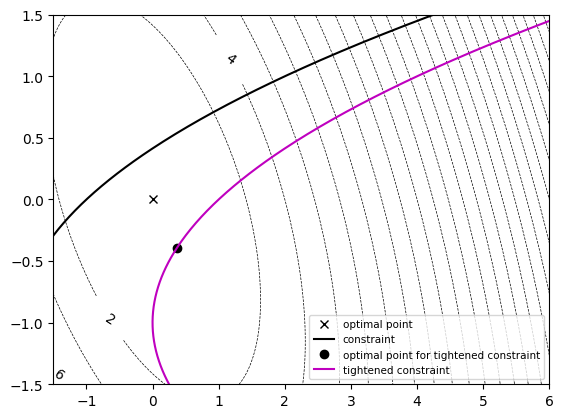

In [2728]:
# Plot for objective function 
def plant_drawing(is_constraint,is_tight_constraint):
        delta = 0.01
        x = np.arange(-6.5, 6.5, delta)
        y = np.arange(-6.5, 6.5, delta)
        u = np.meshgrid(x, y)
        levels = np.linspace(0,50,26)

        CS1 = plt.contour(u[0],u[1],Benoit_System_noiseless_1(u),levels,colors='k',linestyles = "dashed",linewidths = 0.5)
        plt.clabel(CS1,inline=True)
        plt.axis((-1.5, 6.0, -1.5, 1.5))

        if is_constraint == True:
                # Plot for optimal value for optimization with constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_noiseless(u)}) 
                result = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})
                
                ustar = result.x
                print(f"real optimal input: {ustar}")
                fstar = result.fun
                plt.plot(ustar[0],ustar[1],'kx')
                
                # Plot for constraint
                uc0 = 1. + x ** 2 + 2. * x - 2.
                constraint1 = plt.plot(uc0,x,'k')

        if is_tight_constraint == True:

                # Plot for optimal value for optimization with tightened constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_tight_noiseless(u)}) 
                result_tight = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})

                ustar = result_tight.x
                print(f"real optimal input: {ustar}")
                fstar = result_tight.fun
                plt.plot(ustar[0],ustar[1],'ko')

                # Plot for tightened constraint

                uc0t = 1. + x ** 2 + 2. * x
                constraint2 = plt.plot(uc0t,x,'m')

# plant_drawing(is_constraint=True,is_tight_constraint=False)
plant_drawing(is_constraint=True,is_tight_constraint=True)
plt.legend(["optimal point",
            "constraint",
            'optimal point for tightened constraint',
            'tightened constraint'],
                fontsize = 7.5)
plt.show()

# 1. Modifier Adaptation

## A. Benoit Model

In [2729]:
# Plant Model 
def Benoit_Model(u,u0,theta,modifier):

    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2 + modifier[0]*(u[0]-u0[0]) + modifier[1]*(u[1]-u0[1])
    return f

def con1_model(u,u0,theta,modifier):

    g1 = 1. - theta[2]*u[0] + theta[3]*u[1] ** 2 + modifier[2] + modifier[3]*(u[0]-u0[0]) + modifier[4]*(u[1]-u0[1])
    return -g1

# Plant Model 
def Benoit_Model_nomodifier(u,theta):
    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2
    return f

def con1_model_nomodifier(u,theta):
    g1 = 1. - theta[2]*u[0] + theta[3]*u[1] ** 2 
    return -g1


## B. Optimization on Cost Function

In [2730]:
def cost_optimize(u0,theta,modifier):

    con = ({'type': 'ineq',
            'fun': lambda u: con1_model(u,u0,theta,modifier)})
    
    result = minimize((Benoit_Model),
                    u0,
                    constraints= con,
                    method='SLSQP',
                    options= {'ftol': 1e-9},
                    args= (u0,theta,modifier))
    
    return result.x,result.fun

In [2731]:
# # Test
# u0 = [1,1] # Initial guess for optimization algorithm
# modifier = [1,1,1,1,1]
# theta = [0.5,0.5,0.5,0.5]

# u,fun = cost_optimize(u0,theta,modifier)

# print(f"optimal input: {u}, optimal output: {fun}")

## C. Modifier Adaptation

In [2732]:
# gradient modifier
def gradient_estimation(u,fun):
    # step
    du = np.sqrt(1e-3) # np.finfo
    u = np.array(u)
    # Predicted gradient from real plant
    gradient_u0 = (fun(u+[du,0]) - fun(u))/du
    gradient_u1 = (fun(u+[0,du]) - fun(u))/du
    gradient = [gradient_u0,gradient_u1]
    
    return gradient

# Modifier Update
def modifier_update(u,theta,plant_fun,plant_con1):
    
    # Calculate relavent bias and gradients:
    gradient_cost_p = gradient_estimation(u,plant_fun)
    ## Gradient of plant constraint function
    gradient_con1_p = gradient_estimation(u,plant_con1)
    ## Gradient of model cost function
    gradient_cost_m = approx_fprime(u,Benoit_Model_nomodifier,np.sqrt(1e-10),theta)
    ## Gradient of model constraint function
    gradient_con1_m = approx_fprime(u,con1_model_nomodifier,np.sqrt(1e-10),theta)
    ## Gradient of plant cost function

    # Calculate difference between plant and model
    lamda_0 = gradient_cost_p - gradient_cost_m
    epsil = con1_model_nomodifier(u,theta) - plant_con1(u) 
    lamda_1 = gradient_con1_m - gradient_con1_p
    
    return [lamda_0[0],lamda_0[1],epsil,lamda_1[0],lamda_1[1]]

# Modifier Adaptation
def adaptation(u,theta,modifier,plant_fun,plant_con1,K):
    new_modifier = modifier_update(u,theta,plant_fun,plant_con1)
    I = np.identity(len(modifier))

    for i in range(len(modifier)):
        modifier[i] = (I - K)[i,i]*modifier[i] + K[i,i]*new_modifier[i]

    return modifier

In [2733]:
# # Test
# ## Variable
# u = [-0.20316229, -0.80316225]
# u0 = [-1,-1]
# modifier = [1,1,1,1,1]
# theta = [0.5,0.5,0.5,0.5]
# plant_fun = Benoit_System_noiseless_1
# plant_con1 = con1_system_tight_noiseless
# K = np.identity(len(modifier))*0.2

# # Modifier Adaptation
# modifier = adaptation(u,u0,theta,modifier,plant_fun,plant_con1,K)
# print(f"New Modifier: {modifier}")

## D. Overall Algorithm

### I.Plant System 1: 
- "Benoit_System_noiseless_1"
- "con1_system_noiseless" constraint

In [2734]:
# Initial Guess (k=0)
uk = [2,-1]
modifierk = [1,1,1,1,1]
theta = [0.5,0.5,0.5,0.5]
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_noiseless
K = np.identity(len(modifierk))*0.2

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [Benoit_Model(u=uk,u0=uk,theta=theta,modifier=modifierk)]

# Algorithm
for i in range(100):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,theta,modifierk,plant_fun,plant_con1,K)

    uk = uk_1
    modifierk = modifierk_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(modifierk)):
        data['modifiers'][i].append(modifierk[i])
    data['cost'].append(fun) 

print(f"optimal input: {uk}")

optimal input: [-0.01054969 -0.01054969]


### II Result

#### i. Trace of optimal inputs made by Modifier Adaptation Algorithm

real optimal input: [-4.97322951e-09 -4.97201070e-09]


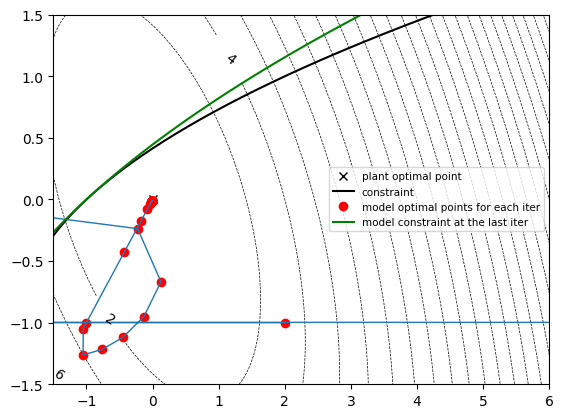

In [2735]:
plant_drawing(is_constraint=True,is_tight_constraint=False)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-2.5, 6.5, delta)
uc0 = (theta[3]*uc1**2 + data['modifiers'][2][-1] - data['modifiers'][3][-1]*data['u_0'][-1] 
       + data['modifiers'][4][-1]*(uc1-data['u_1'][-1]) + 1)/(theta[2] - data['modifiers'][3][-1])
plt.plot(uc0,uc1,'g')

plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)

plt.show()

#### ii. Cost Function through 5 iterations

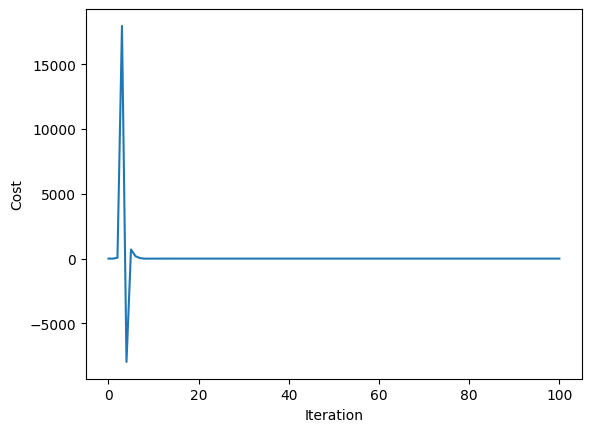

In [2736]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

#### iii. Modifiers of model through 5 iterations

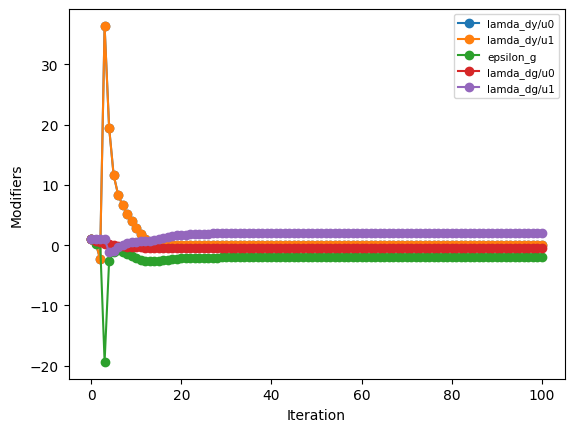

In [2737]:
plt.plot(data['index'],
         data['modifiers'][0],
         data['index'],
         data['modifiers'][1],
         data['index'],
         data['modifiers'][2],
         data['index'],
         data['modifiers'][3],
         data['index'],
         data['modifiers'][4],
         marker='o')
plt.legend(["lamda_dy/u0",
            "lamda_dy/u1",
            "epsilon_g",
            "lamda_dg/u0",
            "lamda_dg/u1"],
            fontsize = 7.5)
plt.xlabel("Iteration"), plt.ylabel("Modifiers")
plt.show()

### III.Plant System_2: 
- "Benoit_System_noiseless_1", 
- "con1_system_tight_noiseless" constraint

In [2738]:
# Initial Guess (k=0)
uk = [2,-1]
modifierk = [1,1,1,1,1]
theta = [1.5,1,1.5,1]
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_tight_noiseless
K = np.identity(len(modifierk))*0.2

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [Benoit_Model(u=uk,u0=uk,theta=theta,modifier=modifierk)]

# Algorithm
for i in range(20):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,theta,modifierk,plant_fun,plant_con1,K)

    uk = uk_1
    modifierk = modifierk_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(modifierk)):
        data['modifiers'][i].append(modifierk[i])
    data['cost'].append(fun) 

print(f"optimal input: {uk}")

optimal input: [ 0.38043336 -0.43871798]


### IV Result

#### i. Trace of optimal inputs made by Modifier Adaptation Algorithm

real optimal input: [ 0.36845785 -0.39299271]


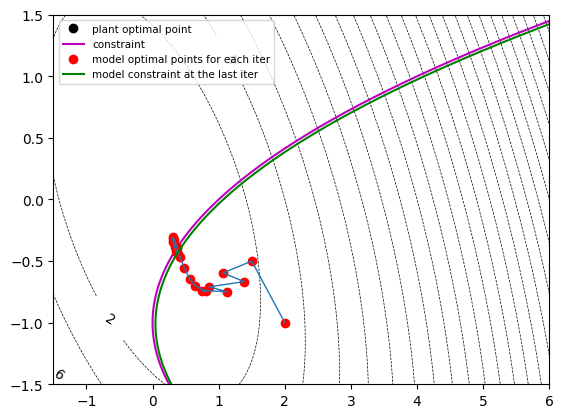

In [2739]:
plant_drawing(is_constraint=False,is_tight_constraint=True)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-2.5, 6.5, delta)
uc0 = (theta[3]*uc1**2 + data['modifiers'][2][-1] - data['modifiers'][3][-1]*data['u_0'][-1] 
       + data['modifiers'][4][-1]*(uc1-data['u_1'][-1]) + 1)/(theta[2] - data['modifiers'][3][-1])
plt.plot(uc0,uc1,'g')
plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

#### ii. Cost Function through 5 iterations

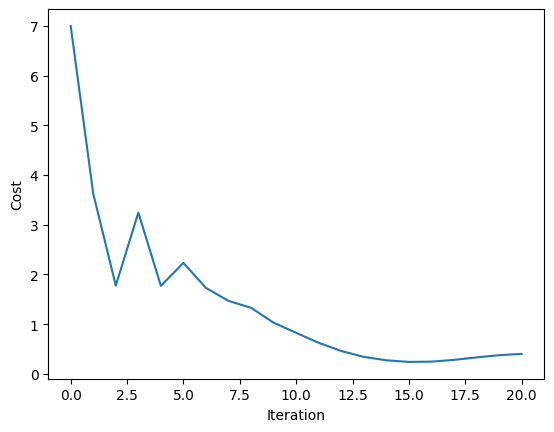

In [2740]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

### III.Plant System_3: 
- "Benoit_System_1", 
- "con1_system_tight" 

In [2741]:
# Initial Guess (k=0)
uk = [2,-1]
modifierk = [1,1,1,1,1]
theta = [1.5,1,1.5,1]
plant_fun = Benoit_System_1
plant_con1 = con1_system_tight
K = np.identity(len(modifierk))*0.2

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [Benoit_Model(u=uk,u0=uk,theta=theta,modifier=modifierk)]

# Algorithm
for i in range(20):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,theta,modifierk,plant_fun,plant_con1,K)

    uk = uk_1
    modifierk = modifierk_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(modifierk)):
        data['modifiers'][i].append(modifierk[i])
    data['cost'].append(fun) 

print(f"optimal input: {uk}")

optimal input: [ 0.37623521 -0.22828849]


real optimal input: [ 0.36845785 -0.39299271]


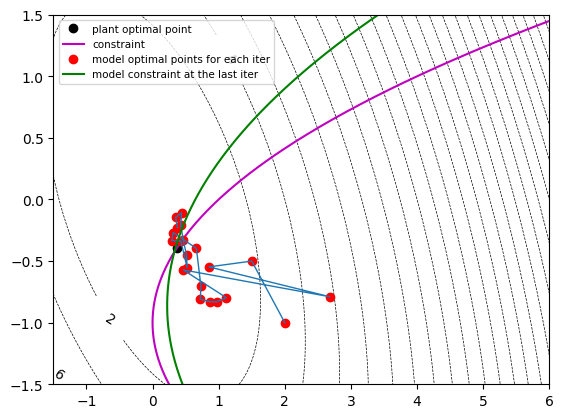

In [2742]:
plant_drawing(is_constraint=False,is_tight_constraint=True)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-2.5, 6.5, delta)
uc0 = (theta[3]*uc1**2 + data['modifiers'][2][-1] - data['modifiers'][3][-1]*data['u_0'][-1] 
       + data['modifiers'][4][-1]*(uc1-data['u_1'][-1]) + 1)/(theta[2] - data['modifiers'][3][-1])
plt.plot(uc0,uc1,'g')
plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

# 2. Setting Initial Values for Parameters by sampling

Values of parameters in the model is not changed in this algorithm. Also, better the initial values of parameters, better the performance of the algorithms. Therefore, setting a good initial values for parameters is vital, which is done in this section. We want to sample the input and output randomly $n_s$ times around the center point $x_i$ within the radius $r$.

## I. Sampling 


In [2743]:
# Source: ML4ChemEng_DataDrivenOpt.ipynb from Dr Antonio Del Rio Chanona
def Ball_sampling(ndim, r_i):
    '''
    This function samples randomly withing a ball of radius r_i
    '''
    u      = np.random.normal(0,1,ndim)  # random sampling in a ball
    norm   = np.sum(u**2)**(0.5)
    r      = random.random()**(1.0/ndim)
    d_init = r*u/norm*r_i*2      # random sampling in a ball

    return d_init

## II. Weight Least Square

We want to find weight least square (error) between the model and the actual output

In [2744]:
# Plant Model 
def Benoit_Model_1(theta,u,u0,modifier):
    '''
    This function is exactly same as Benoit_Model but the order of argument is different; theta is at the front
    for scipy minimize based on theta instead of u
    '''
    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2 + modifier[0]*(u[0]-u0[0]) + modifier[1]*(u[1]-u0[1])
    return f

def con1_model_1(theta,u,u0,modifier):
    '''
    This function is exactly same as Benoit_Model but the order of argument is different; theta is at the front
    for scipy minimize based on theta instead of u
    '''
    g1 = 1. - theta[2]*u[0] + theta[3]*u[1] ** 2 + modifier[2] + modifier[3]*(u[0]-u0[0]) + modifier[4]*(u[1]-u0[1])
    return -g1

# Weight Least Square
def WLS(theta,U,u0,modifier,plant_func,plant_constraint):
    '''
    This function finds the sum of weight least square between 
    plant and model function and constraints
    '''
    n_s = U.shape[0]
    error = 0

    for i in range(n_s):
        error += (Benoit_Model_1(theta,U[i,:],u0,modifier) - plant_func(U[i]))**2/np.abs(plant_func(U[i]))
        error += (con1_model_1(theta,U[i,:],u0,modifier) - plant_constraint(U[i]))**2/np.abs(plant_constraint(U[i]))
        
    return error
    

## III. Parameter Estimation
Estimate parameter using scipy minimize

In [2745]:
def parameter_estimation(U,u0,modifier,plant_func,plant_constraint):
    '''
    U: matrix: [x^(1),...,x^(n_d)]
    Y: vecor:  [f(x^(1)),...,f(x^(n_d))]

    This function estimates parameters of the model using sample U,Y
    '''
    # Initial guess
    p0          = np.array([1,1,1,1])
    # minimizing benoit's model and constraint with scipy minimize
    res         = minimize(WLS, args=(U,u0,modifier,plant_func,plant_constraint), x0=p0, method='BFGS' )
    # obtaining solution
    params      = res.x
    #f_val  = res.fun

    return params

# === first sampling inside the radius === #
n_s = 20                          # number of samples
u_dim = 2                         # dimension for inpu
usample   = np.zeros((n_s+1,u_dim))  # points sampled
fsample = np.zeros((n_s+1))        # function values sampled

# Initial guess
u_0 = [2,-1]                        # Initial guess for u0
f_0 = Benoit_System_noiseless_1(u_0) # Initial guess for f0
modifier = [1,1,1,1,1]  # Initial guess for modifier
r = 0.3                            # radius of a circle that sample will be taken

# sampling loop
for sample_i in range(n_s):
    u_trial = u_0 + Ball_sampling(u_dim, r) # sampling
    usample[sample_i,:] = u_trial
    fsample[sample_i] = Benoit_System_noiseless_1(u_trial)
usample[sample_i+1:] = u_0
fsample[sample_i+1] = f_0

# === Estimate the parameters === #
theta_0      = parameter_estimation(usample,u_0,modifier,Benoit_System_noiseless_1,con1_system_noiseless)
print(f"Initial Parameter estimation: {theta_0}")

Initial Parameter estimation: [0.6090924  0.66826125 3.1788861  0.35672762]


## IV. Use estimated parameter as an initial value for parameter


In [2746]:
# Initial Guess (k=0)
uk = [2,-1]                         # Initial guess for u0
modifierk = [1,1,1,1,1]             # Initial guess for modifier
theta = theta_0                  # Initial value from parameter estimation
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_tight_noiseless
K = np.identity(len(modifierk))*0.2

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [Benoit_Model(u=uk,u0=uk,theta=theta,modifier=modifierk)]

# Algorithm
for i in range(30):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,theta,modifierk,plant_fun,plant_con1,K)
    
    uk = uk_1
    modifierk = modifierk_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(modifierk)):
        data['modifiers'][i].append(modifierk[i])
    data['cost'].append(fun) 

Graph Illustration

real optimal input: [ 0.36845785 -0.39299271]


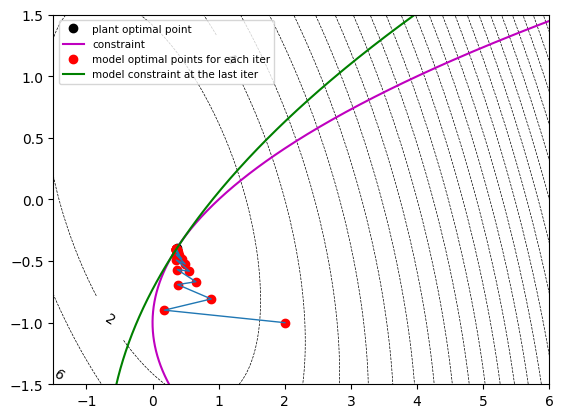

In [2747]:
plant_drawing(is_constraint=False,is_tight_constraint=True)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-2.5, 6.5, delta)
uc0 = (theta[3]*uc1**2 + data['modifiers'][2][-1] - data['modifiers'][3][-1]*data['u_0'][-1] 
       + data['modifiers'][4][-1]*(uc1-data['u_1'][-1]) + 1)/(theta[2] - data['modifiers'][3][-1])
plt.plot(uc0,uc1,'g')
plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

# 3. Trust Region 

Trust region is implemented to use in dual purposes:
1. restricting the step size to the neighbourhood where the cost and constraint are deemed to be predictive
2. define neighbourhood in which additional points are sampled for updating the model



## A. Redifine functions to be w.r.t to distance d

In [2748]:
##########################################
# --- Benoit's Model w.r.t distance --- #
##########################################
def Benoit_Model_d(d,u0,theta,modifier):

    f = theta[0] * (u0[0]+d[0]) ** 2 + theta[1] * (u0[1]+d[1]) ** 2 + modifier[0]*(d[0]) + modifier[1]*(d[1])
    return f

def con1_model_d(d,u0,theta,modifier):

    g1 = 1. - theta[2]*(u0[0]+d[0]) + theta[3]*(u0[1]+d[1]) ** 2 + modifier[2] + modifier[3]*(d[0]) + modifier[4]*(d[1])
    return -g1


########################################################
# --- Optimization on cost function w.r.t distance --- #
########################################################

def cost_optimize_d(r,u0,theta,modifier):
    '''
    Added additional constraint that the distance d
    should be within a circle with radius r
    '''
    d0 = [r/2,r/2]

    con = ({'type': 'ineq',
            'fun': lambda d: con1_model_d(d,u0,theta,modifier)})
    
    con_circle = ({'type': 'ineq',
            'fun': lambda d: r - np.linalg.norm(d)})
    
    result = minimize((Benoit_Model_d),
                    d0,
                    constraints =(con, con_circle),
                    method      ='SLSQP',
                    bounds      = ((-r,r),(-r,r)),
                    options     = {'ftol': 1e-9},
                    args        = (u0,theta,modifier))
    
    return result.x,result.fun

In [2749]:
# # Test
# u0 = [2,-1] # Initial guess for optimization algorithm
# r = 0.2
# modifier = [1,1,1,1,1]
# theta = theta_0

# d,fun = cost_optimize_d(r,u0,theta,modifier)

## B. Trust region update
Update the trust region radius and optimal point based on merit function

In [2750]:
# def trust_region_update(uk,uk_1,funk,funk_1,plant_fun,plant_con1,r,r_red,r_inc):
#     # if current min is bigger than previous min
#     if plant_fun(uk) < plant_fun(uk_1):
#         return uk,funk, r*r_red
#     elif plant_con1(uk_1) < 0:
#         return uk,funk, r*r_red
#     else:
#         pass
    
#     # Calculate merit function
#     rho = (plant_fun(uk) - plant_fun(uk_1))/(funk-funk_1)
#     # if model is good enough
#     if rho > 0.8:
#         if r > 1:
#             return uk_1,funk_1,r
#         else:
#             return uk_1,funk_1,r*r_inc
#     elif rho < 0.2:
#         return uk,funk, r*r_red
    
#     # if model is not good enough
#     else:
#         return uk_1,funk_1, r
    
def trust_region_update(uk,uk_1,funk,funk_1,plant_fun,plant_con1,r,r_red,r_inc):
    # if current min is bigger than previous min
    if plant_fun(uk) < plant_fun(uk_1):
        return uk_1,funk_1, r*r_red
    elif plant_con1(uk_1) < 0:
        return uk_1,funk_1, r*r_red
    else:
        pass
    
    # Calculate merit function
    rho = (plant_fun(uk) - plant_fun(uk_1))/(funk-funk_1)
    # if model is good enough
    if rho > 0.8:
        if r > 1:
            return uk_1,funk_1,r
        else:
            return uk_1,funk_1,r*r_inc
    elif rho < 0.2:
        return uk_1,funk_1, r*r_red
    
    # if model is not good enough
    else:
        return uk_1,funk_1, r



## C. Overall Modifier Adaptation Algorithm

## D. Plant System Example 1:
- "Benoit_System_noiseless_1", 
- "con1_system_tight_noiseless" constraint

In [2751]:
# Initial Guess (k=0)
uk = [2,-1]
modifierk = [1,1,1,1,1]
theta = theta_0
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_tight_noiseless
K = np.identity(len(modifierk))*1
r = 0.2
funk = Benoit_Model_d(d=[0,0],u0=uk,theta=theta,modifier=modifierk)

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['r'] = [r]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [funk]

# Algorithm
for i in range(20):
    dk_1,funk_1 = cost_optimize_d(r,uk,theta,modifierk)
    uk_1 = uk + dk_1
    uk_1,funk_1,r = trust_region_update(uk,uk_1,funk,funk_1,plant_fun,plant_con1,r,0.8,1.2)
    modifierk_1 = adaptation(uk_1,theta,modifierk,plant_fun,plant_con1,K)

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk_1[0])
    data['u_1'].append(uk_1[1])
    data['r'].append(r)
    for i in range(len(modifierk_1)):
        data['modifiers'][i].append(modifierk_1[i])
    data['cost'].append(funk_1)

    # Update variables for next iteration
    uk = uk_1
    funk = funk_1
    modifierk = modifierk_1
print(f"optimal input: {uk}")

optimal input: [ 0.35737514 -0.40222877]


In [ ]:
n_s                 = 5                            # number of samples
n_t                 = 5                             # number of trials
n_i                 = 40                            # number of iterations
plant_fun           = Benoit_System_1
plant_con1          = con1_system_tight

theta = theta_0
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_tight_noiseless
K = np.identity(len(modifierk))*1
r = 0.2

funk = Benoit_Model_d(d=[0,0],u0=uk,theta=theta,modifier=modifierk)

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['r'] = [r]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [funk]



### i. Graphical Illustration

real optimal input: [ 0.36845785 -0.39299271]


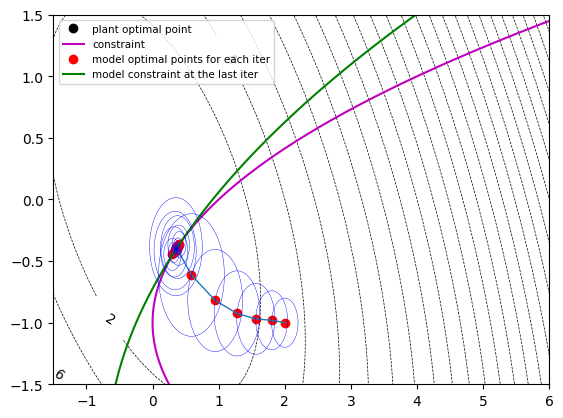

In [2752]:
num_points = 100

plant_drawing(is_constraint=False,is_tight_constraint=True)

plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')

uc1 = np.linspace(-2.5, 6.5, num_points)
uc0 = (theta[3]*uc1**2 + data['modifiers'][2][-1] - data['modifiers'][3][-1]*data['u_0'][-1] 
       + data['modifiers'][4][-1]*(uc1-data['u_1'][-1]) + 1)/(theta[2] - data['modifiers'][3][-1])
plt.plot(uc0,uc1,'g')

i = 0
for i in range(data['index'][-1]+1):
    centerx,centery = data['u_0'][i],data['u_1'][i]
    r = data['r'][i]

    x = np.linspace(centerx-r, centerx+r, 50)
    y = np.linspace(centery-r, centery+r, 50)
    X, Y = np.meshgrid(x,y)
    F = (X-centerx)**2 + (Y-centery)**2 - r**2
    plt.contour(X,Y,F,[0],colors='b',linewidths = 0.3)

plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

### ii. Cost function

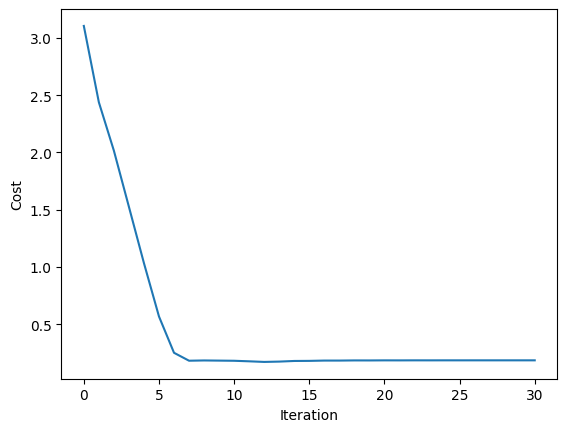

In [2753]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

## E. Plant System Example 2 (with uncertainty):
- "Benoit_System_1", 
- "con1_system_tight" constraint

In [2754]:
# Initial Guess (k=0)
uk = [2,-1]
modifierk = [1,1,1,1,1]
theta = theta_0
plant_fun = Benoit_System_1
plant_con1 = con1_system_tight
K = np.identity(len(modifierk))*1
r = 0.2
funk = Benoit_Model_d(d=[0,0],u0=uk,theta=theta,modifier=modifierk)

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['r'] = [r]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [funk]

# Algorithm
for i in range(40):
    dk_1,funk_1 = cost_optimize_d(r,uk,theta,modifierk)
    uk_1 = uk + dk_1
    uk_1,funk_1,r = trust_region_update(uk,uk_1,funk,funk_1,plant_fun,plant_con1,r,0.8,1.2)
    modifierk_1 = adaptation(uk_1,theta,modifierk,plant_fun,plant_con1,K)


    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk_1[0])
    data['u_1'].append(uk_1[1])
    data['r'].append(r)
    for i in range(len(modifierk_1)):
        data['modifiers'][i].append(modifierk_1[i])
    data['cost'].append(funk_1)

    # Update variables for next iteration
    uk = uk_1
    funk = funk_1
    modifierk = modifierk_1

print(f"optimal input: {uk}")

optimal input: [ 0.7817633  -0.77025627]


### i. Graphical Illustration

real optimal input: [ 0.36845785 -0.39299271]


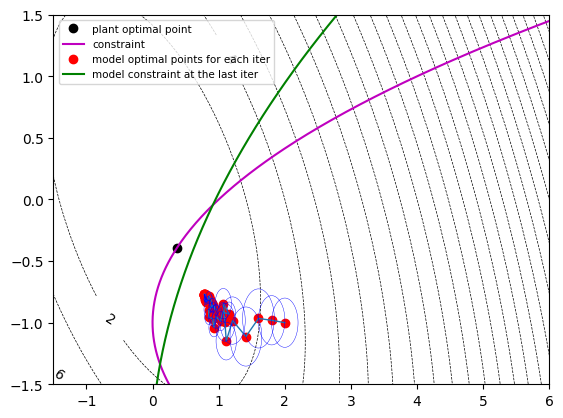

In [2755]:
num_points = 100

plant_drawing(is_constraint=False,is_tight_constraint=True)

plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')

uc1 = np.linspace(-2.5, 6.5, num_points)
uc0 = (theta[3]*uc1**2 + data['modifiers'][2][-1] - data['modifiers'][3][-1]*data['u_0'][-1] 
       + data['modifiers'][4][-1]*(uc1-data['u_1'][-1]) + 1)/(theta[2] - data['modifiers'][3][-1])
plt.plot(uc0,uc1,'g')

i = 0
for i in range(data['index'][-1]+1):
    centerx,centery = data['u_0'][i],data['u_1'][i]
    r = data['r'][i]

    x = np.linspace(centerx-r, centerx+r, 50)
    y = np.linspace(centery-r, centery+r, 50)
    X, Y = np.meshgrid(x,y)
    F = (X-centerx)**2 + (Y-centery)**2 - r**2
    plt.contour(X,Y,F,[0],colors='b',linewidths = 0.3)

plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

### ii. Cost function

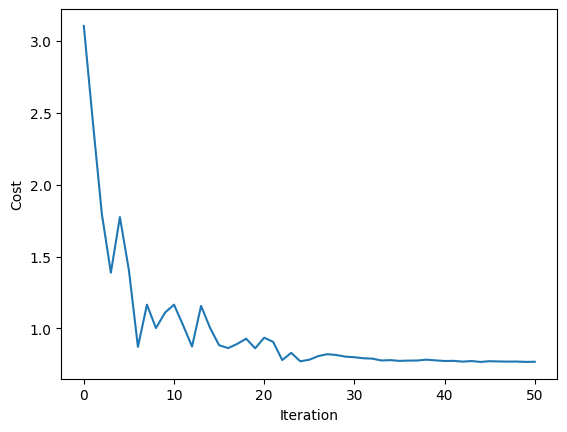

In [2756]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()